In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [ ]:

import json
import math
import os
import keras
import time
import cv2
from PIL import Image
import numpy as nnhmjdj
from keras import layers
#from keras.applications import ResNet50,Vbdhdh hjdjn jet50
from keras.applications.vgg16 import VGG16


from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
#from keras.optimizers import Adam

from keras.optimizers import adam_v2


import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

cloudy_train = np.array(Dataset_loader('weather_dataset/train/cloudy',64))
shine_train = np.array(Dataset_loader('weather_dataset/train/shine',64))
rain_train = np.array(Dataset_loader('weather_dataset/train/rain',64))
sunrise_train = np.array(Dataset_loader('weather_dataset/train/sunrise',64))

cloudy_val = np.array(Dataset_loader('weather_dataset/val/cloudy',64))
shine_val = np.array(Dataset_loader('weather_dataset/val/shine',64))
rain_val = np.array(Dataset_loader('weather_dataset/val/rain',64))
sunrise_val = np.array(Dataset_loader('weather_dataset/val/sunrise',64), Hgfsbtbvynyb ingig)


100%|██████████| 57/57 [00:23<00:00,  2.46it/s]


In [ ]:

# Create labels
cloudy_train_label = np.zeros(len(cloudy_train))
shine_train_label = np.ones(len(shine_train))
rain_train_label = np.ones(len(rain_train))*2
sunrise_train_label = np.ones(len(sunrise_train))*3

cloudy_val_label = np.zeros(len(cloudy_val))
shine_val_label = np.ones(len(shine_val))
rain_val_label = np.ones(len(rain_val))*2
sunrise_val_label = np.ones(len(sunrise_val))*3

print('len',len(cloudy_train), len(shine_train), len(rain_train), len(sunrise_train))
print('len',len(cloudy_train_label), len(shine_train_label), len(rain_train_label), len(sunrise_train_label))

# Merge data
X_train = np.concatenate((cloudy_train, shine_train, rain_train, sunrise_train), axis = 0)
Y_train = np.concatenate((cloudy_train_label, shine_train_label, rain_train_label, sunrise_train_label), axis = 0)
X_test = np.concatenate((cloudy_val, shine_val, rain_val, sunrise_val), axis = 0)
Y_test = np.concatenate((cloudy_val_label, shine_val_label, rain_val_label, sunrise_val_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 4)
Y_test = to_categorical(Y_test, num_classes= 4)

len 245 224 189 299
len 245 224 189 299


In [ ]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [ ]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(4, activation='softmax'))


    model.compile(
        loss='binary_crossentropy',
        optimizer=adam_v2.Adam(lr=lr),
        metrics=['accuracy']
    )

    return model

In [ ]:

resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(64,64,3)
)

resnet_model = build_model(resnet ,lr = 1e-4)
resnet_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
vggnet = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(64,64,3)
)

vggnet_model = build_model(vggnet ,lr = 1e-4)
vggnet_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath_res="weather_resnet50_64x64.hdf5"
filepath_vgg="weather_vgg16_64x64.hdf5"
checkpoint_res = ModelCheckpoint(filepath_res, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
checkpoint_vgg = ModelCheckpoint(filepath_vgg, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [ ]:

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback_res = TimeHistory()
time_callback_vgg = TimeHistory()


In [ ]:
resnet_history = resnet_model.fit_generator(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, Y_test),
    callbacks=[learn_control, checkpoint_res, time_callback_res]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
60/59 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.4608WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00001: saving model to weather_resnet50_64x64.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


59/59 [==============================] - 134s 2s/step - loss: 0.7177 - accuracy: 0.4608 - val_loss: 0.7822 - val_accuracy: 0.5879 - lr: 1.0000e-04
Epoch 2/20
60/59 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.6729WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00002: saving model to weather_resnet50_64x64.hdf5
59/59 [==============================] - 129s 2s/step - loss: 0.5458 - accuracy: 0.6729 - val_loss: 0.5493 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 3/20
60/59 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.7534WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00003: saving model to weather_resnet50_64x64.hdf5
59/59 [==============================] - 126s 2s/step - loss: 0.4299 - accur

In [ ]:
 vggnet_history = vggnet_model.fit_generator(
    train_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(X_test, Y_test),
    callbacks=[learn_control, checkpoint_vgg, time_callback_vgg]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
60/59 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.4566WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00001: saving model to weather_vgg16_64x64.hdf5
59/59 [==============================] - 157s 3s/step - loss: 0.6538 - accuracy: 0.4566 - val_loss: 0.9346 - val_accuracy: 0.3152 - lr: 1.0000e-04
Epoch 2/20
60/59 [==============================] - ETA: 0s - loss: 0.5476 - accuracy: 0.5987WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00002: saving model to weather_vgg16_64x64.hdf5
59/59 [==============================] - 151s 3s/step - loss: 0.5476 - accuracy: 0.5987 - val_loss: 0.6919 - val_accuracy: 0.4182 - lr: 1.0000e-04
Epoch 3/20
60/59 [==============================] - ETA: 0s - loss: 0.4957 - accur

In [ ]:
with open('history_vgg.json', 'w') as f:
    json.dump(str(vggnet_history.history), f)

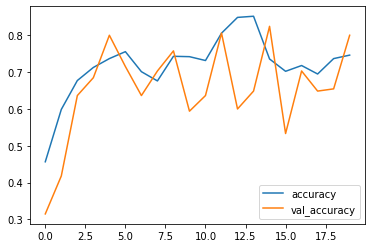

In [ ]:
vgg_history_df = pd.DataFrame(vggnet_history.history)
vgg_history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
vgg_history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.653806,0.456635,0.934620,0.315152,0.0001
1,0.547616,0.598746,0.691938,0.418182,0.0001
2,0.495736,0.677116,0.510620,0.636364,0.0001
3,0.439322,0.712644,0.420886,0.684848,0.0001
4,0.400799,0.736677,0.353874,0.800000,0.0001
5,0.373158,0.755486,0.624095,0.715151,0.0001
6,0.397890,0.701149,0.600886,0.636364,0.0001
7,0.401813,0.676071,0.396544,0.703030,0.0001
8,0.334231,0.742947,0.336474,0.757576,0.0001
9,0.320651,0.741902,1.395190,0.593939,0.0001


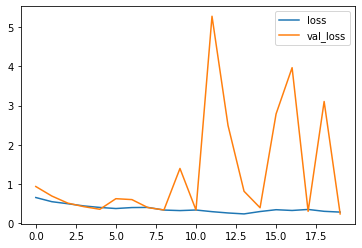

In [ ]:
vgg_history_df = pd.DataFrame(vggnet_history.history)
vgg_history_df[['loss', 'val_loss']].plot()

In [ ]:
with open('history_resnet.json', 'w') as f:
    json.dump(str(resnet_history.history), f)

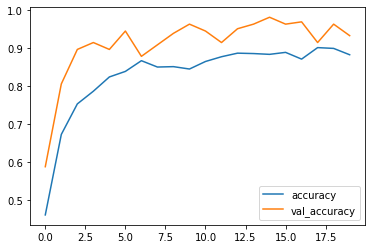

In [ ]:
resnet_history_df = pd.DataFrame(resnet_history.history)
resnet_history_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
resnet_history_df

,loss,accuracy,val_loss,val_accuracy,lr
0,0.717687,0.460815,0.782154,0.587879,0.0001
1,0.545827,0.672936,0.549330,0.806061,0.0001
2,0.429864,0.753396,0.353604,0.896970,0.0001
3,0.387670,0.786834,0.300803,0.915152,0.0001
4,0.320802,0.824451,0.276410,0.896970,0.0001
5,0.304170,0.839080,0.225992,0.945455,0.0001
6,0.248977,0.867294,0.247362,0.878788,0.0001
7,0.256201,0.850575,0.191585,0.909091,0.0001
8,0.239758,0.851620,0.134093,0.939394,0.0001
9,0.261861,0.845350,0.092529,0.963636,0.0001


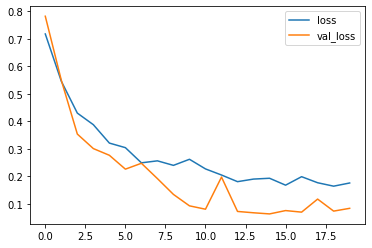

In [ ]:
resnet_history_df = pd.DataFrame(resnet_history.history)
resnet_history_df[['loss', 'val_loss']].plot()

In [ ]:
## Resnet performed better than vggnet

In [ ]:
def prediction(test_path):
    img = image.load_img(test_path , target_size = (250 , 250))
    img = image.img_to_array(img, dtype=np.uint8)
    img = np.array(img)/255.0

    plt.title('Img')
    plt.axis('off')
    plt.imshow(img.squeeze())

    predict = model.predict(img[np.newaxis , ...])
    predicted_class = labels[np.argmax(predict[0] , axis = -1)]

    print('Prediction Value: ' , np.max(predict[0] , axis = -1))
    print("Classified:",predicted_class)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [ ]:
base_dir =  r'/content/gdrive/MyDrive/weather_dataset/train'
folders = os.listdir(base_dir)
print(folders)

['shine', 'cloudy', 'sunrise', 'rain']


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(250 , 250),
    batch_size= 32,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    base_dir, # same directory as training data
    target_size=(250, 250),
    batch_size= 32,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 769 images belonging to 4 classes.
Found 191 images belonging to 4 classes.


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v , k) for k , v in labels.items())
print(labels)

{0: 'cloudy', 1: 'rain', 2: 'shine', 3: 'sunrise'}


In [ ]:
num_classes = 4

# defining model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), input_shape = (250 , 250 , 3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(3,3),
    tf.keras.layers.Conv2D(64, (5,5) , activation = 'relu'),
    tf.keras.layers.MaxPool2D((3,3)),
    tf.keras.layers.Conv2D(128 , (5,5) , activation = 'relu'),
    tf.keras.layers.MaxPool2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5, seed = 5),
    tf.keras.layers.Dense(128 , activation = 'relu'),
    tf.keras.layers.Dense(num_classes , activation = 'softmax')])

Prediction Value:  0.2678643
Classified: shine


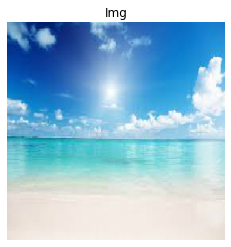

In [ ]:
test_path = r"/content/gdrive/MyDrive/weather_dataset/train/shine/shine103.jpg"
prediction(test_path)

Prediction Value:  0.26797774
Classified: shine


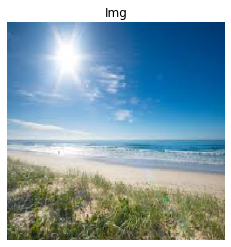

In [ ]:
test_path = r"/content/gdrive/MyDrive/weather_dataset/train/shine/shine107.jpg"
prediction(test_path)


Prediction Value:  0.26187754
Classified: cloudy


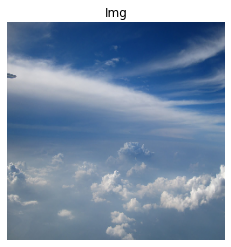

In [ ]:
test_path = r"/content/gdrive/MyDrive/weather_dataset/train/cloudy/cloudy116.jpg"
prediction(test_path)
